# 실습:  CNN을 이용한 폐렴 검출

The code below is copied from
 https://www.kaggle.com/kashyapgohil/pneumonia-detection-using-cnn

 The Author of the code is Kashyap Gohil

 영상 데이터셋은 다음 링크에서 얻을 수 있다: 
 https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia 

데이터셋에 대한 설명:
데이터 세트는 3개의 폴더(train, test, validation)로 구성되며 각각에 대하여 클래스 (폐렴/정상)에 대한 하위 폴더를 포함하고 있다. 본 데이터세트는 5,863개의 X선 영상(JPEG)으로 이루어졌고,광저우시 광저우 여성아동병원에서 1~5세 소아환자를 대상으로 촬영한 흉부 X선 영상이다. 저품질 또는 판독이 불가능한 영상은 제외가 되었고, 두 명의 전문의에 의해 이미지에 대한 진단 점수가 매겨졌다. 

In [ ]:
# 구글 코랩으로 파일을 업로드하기 (archive.zip으로 저장하였음)
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [ ]:
# 압축파일 풀기
!unzip archive.zip

Archive:  archive.zip
   creating: archive/chest_xray/
   creating: archive/chest_xray/test/
   creating: archive/chest_xray/test/NORMAL/
  inflating: archive/chest_xray/test/NORMAL/NORMAL2-IM-0287-0001.jpeg  
  inflating: archive/chest_xray/test/NORMAL/NORMAL2-IM-0288-0001.jpeg  
  inflating: archive/chest_xray/test/NORMAL/NORMAL2-IM-0289-0001.jpeg  
  inflating: archive/chest_xray/test/NORMAL/NORMAL2-IM-0290-0001.jpeg  
  inflating: archive/chest_xray/test/NORMAL/NORMAL2-IM-0292-0001.jpeg  
  inflating: archive/chest_xray/test/NORMAL/NORMAL2-IM-0294-0001.jpeg  
  inflating: archive/chest_xray/test/NORMAL/NORMAL2-IM-0297-0001.jpeg  
  inflating: archive/chest_xray/test/NORMAL/NORMAL2-IM-0300-0001.jpeg  
  inflating: archive/chest_xray/test/NORMAL/NORMAL2-IM-0301-0001.jpeg  
  inflating: archive/chest_xray/test/NORMAL/NORMAL2-IM-0302-0001.jpeg  
  inflating: archive/chest_xray/test/NORMAL/NORMAL2-IM-0303-0001.jpeg  
  inflating: archive/chest_xray/test/NORMAL/NORMAL2-IM-0304-0001.jpeg 

In [ ]:
# 필요한 모듈 import하기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:
# 파일로부터 영상을 읽어서 data에 저장하기
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
ls

archive/  archive.zip  sample_data/


In [ ]:
cd archive

/content/archive


In [ ]:
ls

chest_xray/


In [ ]:
cd chest_xray

/content/archive/chest_xray


In [ ]:
ls

test/  train/


In [ ]:
cd ..

/content/archive


In [ ]:
train = get_training_data('./chest_xray/train')
test = get_training_data('./chest_xray/test')
#val = get_training_data('./chest_xray/val')

<ipython-input-6-baadddfbe286>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
print(train[500][1])

1


In [ ]:
train.shape

(619, 2)

In [ ]:
for feature, label in train:
  print(feature)
  print(label)

[[32 38 41 ... 48 46 42]
 [34 37 43 ... 49 47 47]
 [34 37 58 ... 49 46 45]
 ...
 [39 74 57 ... 20 21 21]
 [48 72 62 ... 21 22 14]
 [37 70 61 ... 22 23 23]]
0
[[209 201 180 ...  73  80  68]
 [211 192 195 ...  82  85  69]
 [189 195 178 ...  84  89  69]
 ...
 [ 22  21  21 ...  27  27  27]
 [ 22  21  21 ...  27  27  27]
 [ 22  21  21 ...  27  27  27]]
0
[[16 15 15 ... 32 22  0]
 [13 13 13 ... 33 28 17]
 [13 12 11 ... 35 30 24]
 ...
 [26 25 24 ... 23 24 21]
 [25 25 25 ... 23 23 24]
 [25 25 25 ... 23 23 24]]
0
[[103 106 106 ...   0   0   0]
 [ 99 109 110 ...   0   0   0]
 [101 106 110 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
0
[[158 162 173 ... 210 214 217]
 [169 171 178 ... 214 214 213]
 [164 165 168 ... 207 207 205]
 ...
 [ 96 101 110 ...  31  32  39]
 [115 119  84 ...  31  31  31]
 [103  91  99 ...  31  31  31]]
0
[[59 57 61 ... 59 61 63]
 [60 58 61 ... 64 65 66]
 [60 61 60 ... 63 66 66]
 ...
 [41 53 68 ... 18 20 2

In [ ]:
#폐렴과 정상 데이터의 갯수 확인하기
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

ValueError: ignored

Text(0.5, 1.0, 'NORMAL')

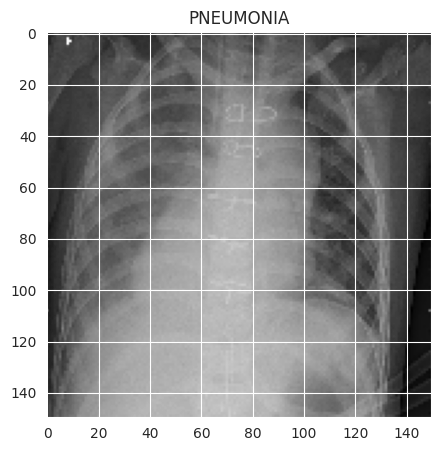

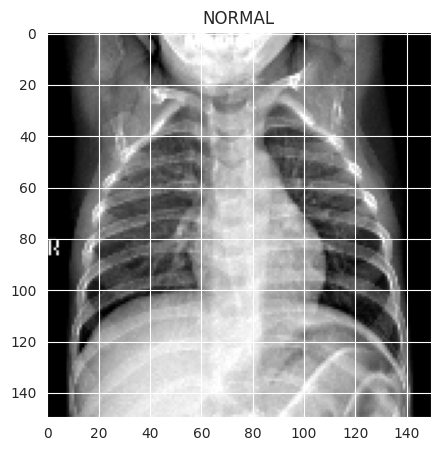

In [ ]:
#영상으로 보이기
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
#for feature, label in val:
#    x_val.append(feature)
#    y_val.append(label)

In [ ]:
# 데이터를 Normalize 0~255  --->   0~1
x_train = np.array(x_train) / 255
#x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# 딥러닝을 위해 data를 resize
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

#x_val = x_val.reshape(-1, img_size, img_size, 1)
#y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
# data augmentation하기 (overfitting을 막고, 데이터셋내의 데이터 불균형도 어느 정도 해소)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
# 모델을 만들기
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [ ]:
#learning_rate를 줄이는 방법. 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 ,callbacks = [learning_rate_reduction])

Epoch 1/12
20/20 [==============================] - ETA: 0s - loss: 1.6902 - accuracy: 0.7674

20/20 [==============================] - 30s 1s/step - loss: 1.6902 - accuracy: 0.7674 - lr: 0.0010
Epoch 2/12
20/20 [==============================] - ETA: 0s - loss: 0.3453 - accuracy: 0.8691

20/20 [==============================] - 29s 1s/step - loss: 0.3453 - accuracy: 0.8691 - lr: 0.0010
Epoch 3/12
20/20 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.8756

20/20 [==============================] - 27s 1s/step - loss: 0.3023 - accuracy: 0.8756 - lr: 0.0010
Epoch 4/12
20/20 [==============================] - ETA: 0s - loss: 0.3895 - accuracy: 0.8788

20/20 [==============================] - 27s 1s/step - loss: 0.3895 - accuracy: 0.8788 - lr: 0.0010
Epoch 5/12
20/20 [==============================] - ETA: 0s - loss: 0.2654 - accuracy: 0.8950

20/20 [==============================] - 27s 1s/step - loss: 0.2654 - accuracy: 0.8950 - lr: 0.0010
Epoch 6/12
20/20 [==============================] - ETA: 0s - loss: 0.3127 - accuracy: 0.8853

20/20 [==============================] - 28s 1s/step - loss: 0.3127 - accuracy: 0.8853 - lr: 0.0010
Epoch 7/12
20/20 [==============================] - ETA: 0s - loss: 0.4420 - accuracy: 0.8821

20/20 [==============================] - 27s 1s/step - loss: 0.4420 - accuracy: 0.8821 - lr: 0.0010
Epoch 8/12
20/20 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.8950

20/20 [==============================] - 27s 1s/step - loss: 0.2879 - accuracy: 0.8950 - lr: 0.0010
Epoch 9/12
20/20 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9241

20/20 [==============================] - 27s 1s/step - loss: 0.1984 - accuracy: 0.9241 - lr: 0.0010
Epoch 10/12
20/20 [==============================] - ETA: 0s - loss: 0.2704 - accuracy: 0.9031

20/20 [==============================] - 27s 1s/step - loss: 0.2704 - accuracy: 0.9031 - lr: 0.0010
Epoch 11/12
20/20 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.9031

20/20 [==============================] - 27s 1s/step - loss: 0.2866 - accuracy: 0.9031 - lr: 0.0010
Epoch 12/12
20/20 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.9305

20/20 [==============================] - 27s 1s/step - loss: 0.1815 - accuracy: 0.9305 - lr: 0.0010


In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

2/2 [==============================] - 1s 115ms/step - loss: 30.0869 - accuracy: 0.4545
Loss of the model is -  30.086942672729492
2/2 [==============================] - 0s 131ms/step - loss: 30.0869 - accuracy: 0.4545
Accuracy of the model is -  45.45454680919647 %


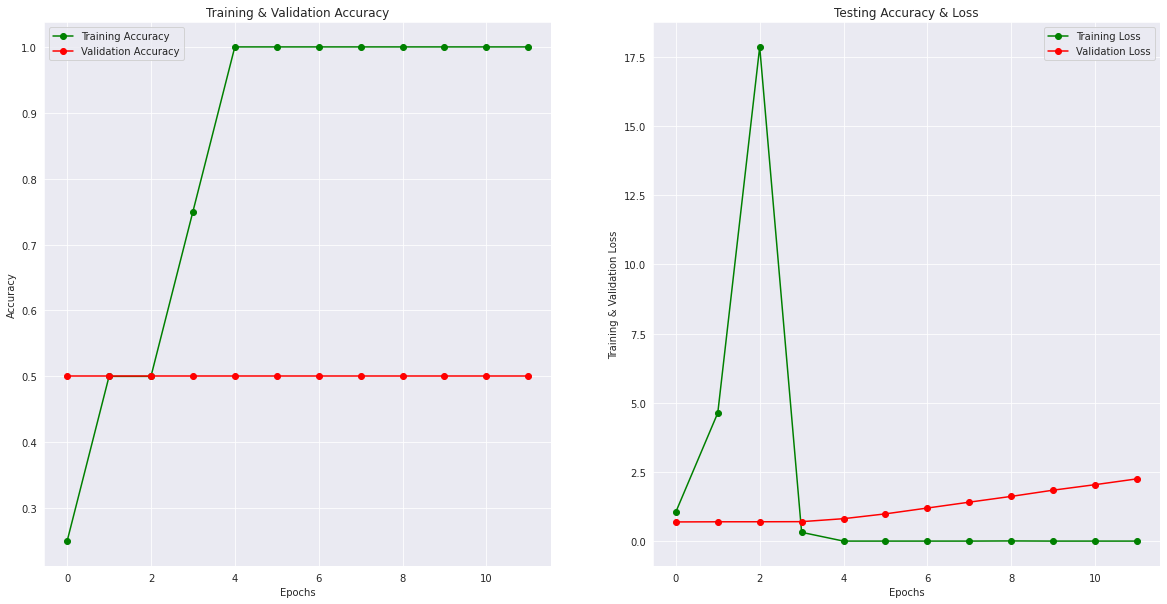

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.50      1.00      0.67         2
   Normal (Class 1)       0.00      0.00      0.00         2

           accuracy                           0.50         4
          macro avg       0.25      0.50      0.33         4
       weighted avg       0.25      0.50      0.33         4



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[2, 0],
       [2, 0]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

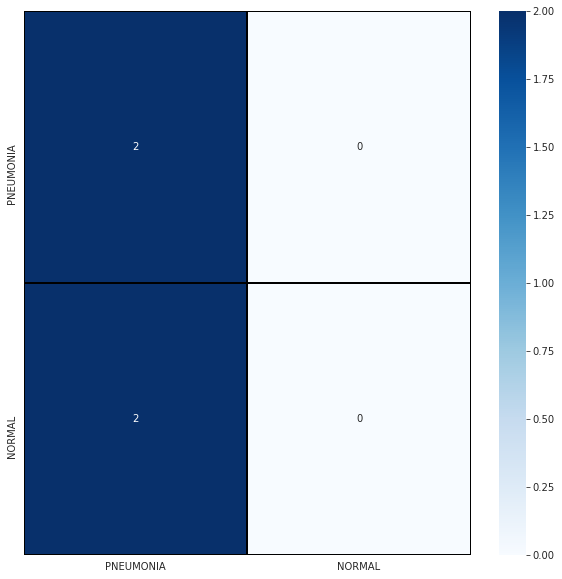

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

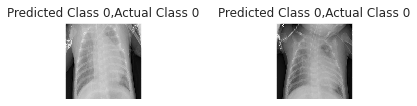

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [ ]:
#model.save(../model.h5)